### Домашня работа 2.
### Логистическая регрессия. Работа с признаками


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 15 баллов. Можно получить 4.5 бонусных балла.

Неэффективная реализация кода может негативно отразиться на оценке.

In [1]:
print('Всем удачи!👒 Тут она точно пригодится.')

Всем удачи!👒 Тут она точно пригодится.


In [2]:
%pylab inline
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Часть 1. Логистическая регрессия своими руками (4 балла)

Реализуйте логистическую регрессию, обучаемую с помощью:

**Задание 1 (1.5 балла). Градиентного спуска**

**Задание 2 (1.5 балла). Стохастического градиентного спуска**

Во всех пунктах необходимо соблюдать следующие условия:
- Градиентный спуск необходимо записать в векторном виде
- Циклы средствами python допускается использовать только для итераций градиентного спуска;
- В качестве критерия останова необходимо использовать (одновременно):

        проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) задаваемого параметром `tolerance`;


        достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса loss_history. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту);

Инициализировать веса можно случайным образом или нулевым вектором.

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

In [3]:
from sklearn.base import BaseEstimator
from sklearn.metrics import log_loss
from scipy.special import expit


class LogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic', 
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic' 
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        #self.alpha = alpha
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration
    
    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        # not optimal but for the most part of the excersice we will
        # receive pd data frames
        self.loss_history = []
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)


        self.w = np.random.randn(X.shape[1]) * 0.01
        self.loss_history = []
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        for _ in range(self.max_iter):
            if self.gd_type == 'stochastic':
                j = np.random.randint(0, len(X))
                single_X = X.iloc[j].values.reshape(1, -1)
                gradient = self.calc_gradient(single_X, y[j])
            elif self.gd_type == 'full':
                gradient = self.calc_gradient(X, y)
            
            new_w = self.w - self.eta * gradient
            if np.linalg.norm(new_w - self.w) < self.tolerance:
                print('Early termination')
                break

            self.w = new_w
            self.loss_history.append(self.calc_loss(X, y))
        return self
    
    
    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        return expit(X @ self.w)
    
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        return (self.predict_proba(X) > 0.5).astype(int)
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        return X.T @ (self.predict_proba(X) - y)

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float 
        """ 
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        return (1/len(y)) * log_loss(y, self.predict_proba(X))

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc


# helper functions

def plot_pr_roc_curve(y_true, y_pred):
    precision, recall, threshold = precision_recall_curve(y_true, y_pred)
    roc_auc = auc(recall, precision)
    plt.title('PR ROC')
    plt.plot(recall, precision, 'b', label = 'AUC = %0.6f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('precision')
    plt.xlabel('recall')
    plt.show()

def plot_roc_curve(y_true, y_pred):
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.title('ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.6f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def plot_loss_progression(model):
    sns.lineplot(x=range(len(model.loss_history)), y=model.loss_history)
    plt.xlabel('epoch')
    plt.ylabel('log loss value')
    plt.title('Loss reduction')
    plt.show()

Синтетические данные

In [5]:
#%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [6]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)


**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

**Задание 3 (1 балл)**

Обучите логистическую регрессию на синтетических данных.

Early termination


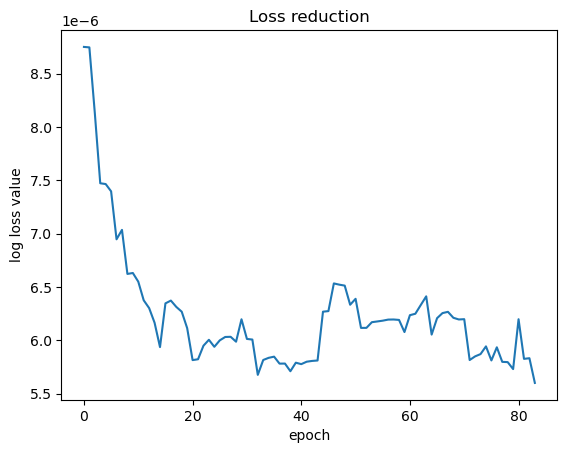

CPU times: user 4.76 s, sys: 15.4 s, total: 20.1 s
Wall time: 1.38 s


In [7]:
%%time

### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

import matplotlib.pyplot as plt
import seaborn as sns

model = LogReg()

model.fit(X_train, y_train)


plot_loss_progression(model=model)

In [8]:
y_pred_test = model.predict(X_test)

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

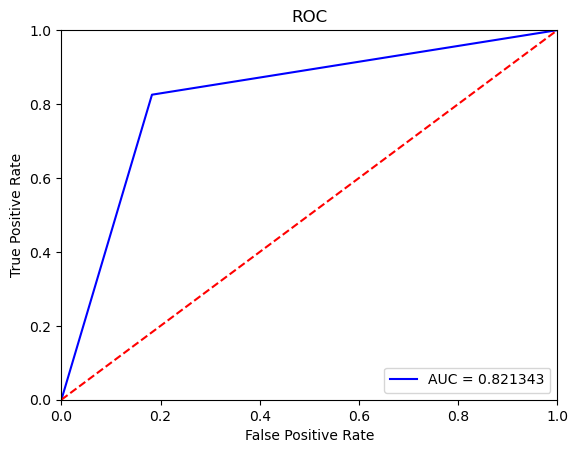

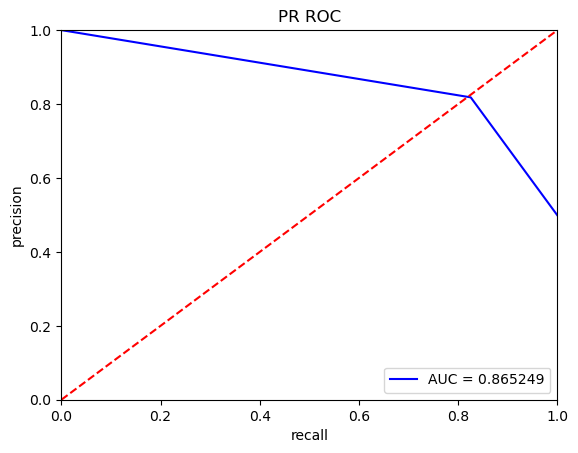

In [9]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plot_roc_curve(y_true=y_test, y_pred=y_pred_test)
plot_pr_roc_curve(y_true=y_test, y_pred=y_pred_test)

> __Ответ__: Модель обладает хорошими предсказательными способностями. Площадь про под ROC - кривой составляет 0.82. Это говорит о том, что прогноз модели даст большую вероятность положтельному классу и меньшую вероятность отрицательному. <br> Касательно PR-ROC = 0.86 модель предоставляет хороший баланс между чувствительностью и точностью.

## Часть 2. Работа с категориальными переменными (3 балла)

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные с конкурса  [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом для задания мы немного модифицируем датасет.

In [10]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.


In [11]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

**Задание 5 (0 баллов).** Посчитайте качество (в этом задании будем работать c ROC-AUC) на исходных признаках при применении логистической регрессии.

In [12]:
%%time
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)

Early termination
CPU times: user 168 ms, sys: 426 ms, total: 594 ms
Wall time: 53.8 ms


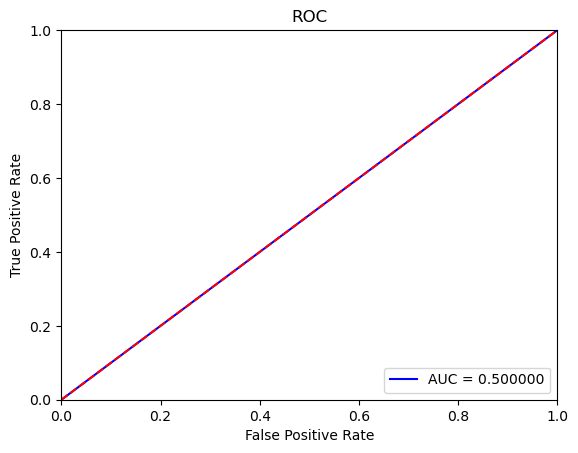

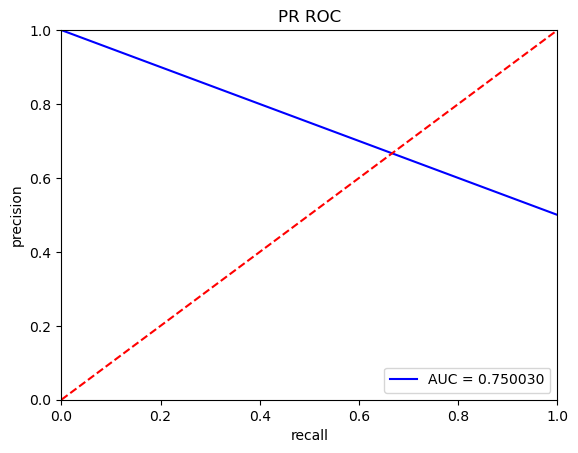

In [13]:
plot_roc_curve(y_true=y_test, y_pred=y_pred_test)
plot_pr_roc_curve(y_true=y_test, y_pred=y_pred_test)

**Задание 6 (0.5 балла).** Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на обучение модели.

In [14]:
%%time

### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from category_encoders.one_hot import OneHotEncoder

cat_features = X_train.columns[X_train.columns.str.endswith('cat')]

ohe = OneHotEncoder(cols=cat_features)
ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train)
X_test_ohe = ohe.transform(X_test)

# drop first
X_train_ohe.drop(columns=cat_features + '_1', inplace=True)
X_test_ohe.drop(columns=cat_features + '_1', inplace=True)

CPU times: user 2.49 s, sys: 1.41 s, total: 3.9 s
Wall time: 3.89 s


In [15]:
%%time
model.fit(X_train_ohe, y_train)
y_pred_test = model.predict(X_test_ohe)

CPU times: user 5min 19s, sys: 14min 52s, total: 20min 12s
Wall time: 1min 20s


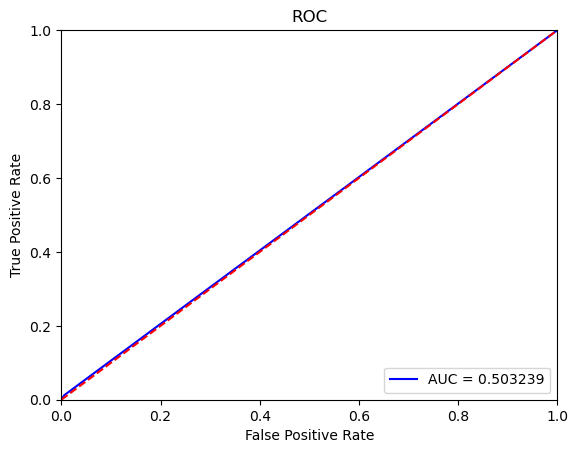

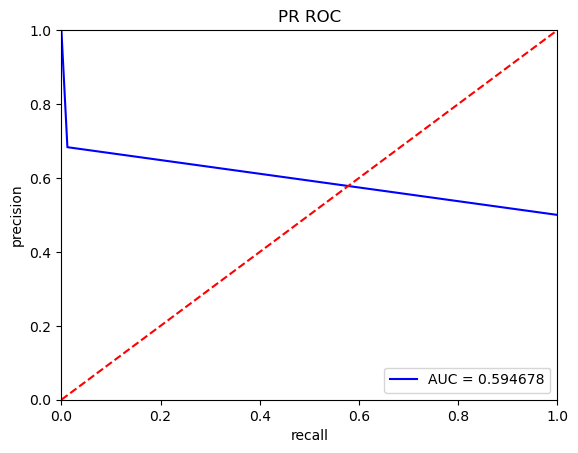

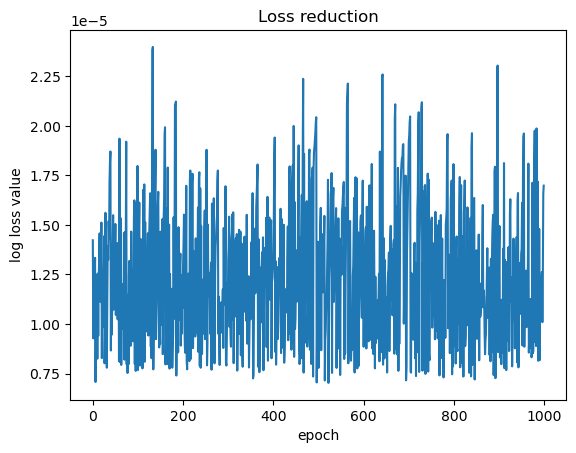

In [16]:
plot_roc_curve(y_true=y_test, y_pred=y_pred_test)
plot_pr_roc_curve(y_true=y_test, y_pred=y_pred_test)
plot_loss_progression(model=model)

> __Ответ__: на обучение модели потребовалось 1 минута 17 секунд + 4 секунды для создания OneHot кодирования категорильных переменных. Площадь под ROC кривой составляет 0.503, что говорит об очень низкой предсказательной способности модели.

Как можно было заменить, one-hot-кодирование сильно увилечивает количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 7 (1.5 балла).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментом. Заметили ли вы что-то интересное?


In [17]:
from sklearn.base import TransformerMixin

class MyTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols, sigma=0.0):
        self.cols = cols
        self.noise = np.random.randn() * sigma
    
    def fit(self, X: pd.DataFrame, y):

        X['target'] = y
        self.cols_dict = {}
        for col in self.cols:
            # calculates average for each category of the column
            self.cols_dict[col] = X['target'].groupby(X_train[col]).agg(['mean']).to_dict()['mean']
        X.drop(columns=['target'], inplace=True)
        return self
    
    def transform(self, X):
        # for each colum we map calculated values
        for col in self.cols:
            X[col] = X[col].map(self.cols_dict[col]) + self.noise
        return X

In [18]:
%%time

### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
my_target_encoder = MyTargetEncoder(cols=cat_features, sigma=0)

my_target_encoder.fit(X_train, y_train)

X_train_my_target = my_target_encoder.transform(X_train)
X_test_my_target = my_target_encoder.transform(X_test)

CPU times: user 60.3 ms, sys: 997 µs, total: 61.3 ms
Wall time: 60.9 ms


In [19]:
%%time
model.fit(X_train_my_target, y_train)
y_pred_test = model.predict(X_test_my_target)

CPU times: user 2min 12s, sys: 7min 32s, total: 9min 45s
Wall time: 37.5 s


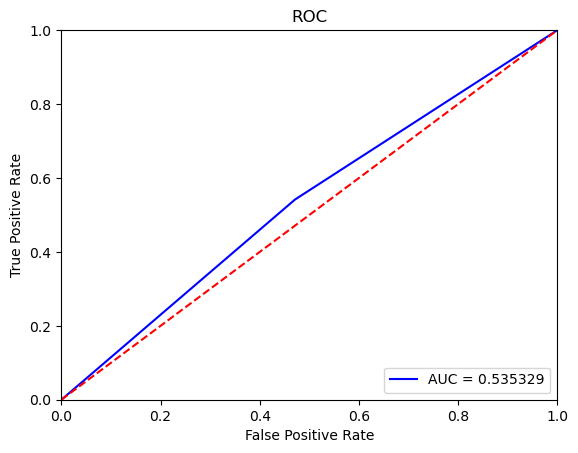

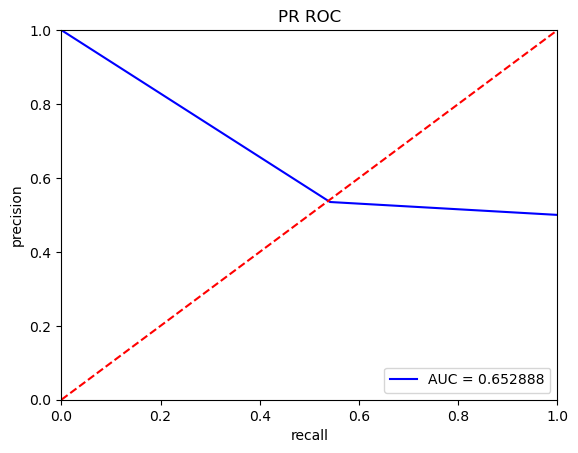

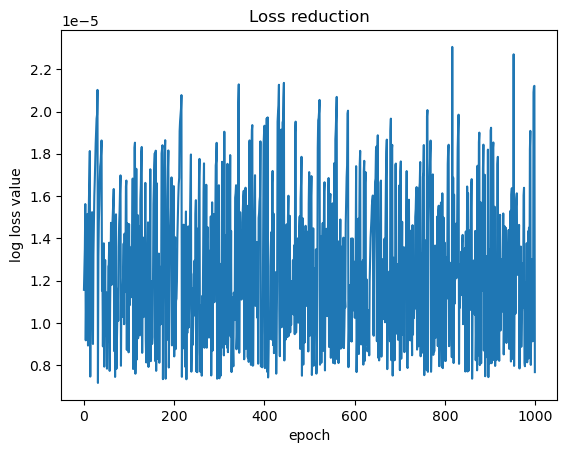

In [20]:
plot_roc_curve(y_true=y_test, y_pred=y_pred_test)
plot_pr_roc_curve(y_true=y_test, y_pred=y_pred_test)
plot_loss_progression(model=model)

> __Ответ__: Target кодирование категориальных переменных отработало существенно быстрее - 62ms, так как нам не потребовалось создавать дополнительных переменных. Из-за того, что у нас получилось намного меньше признаков модель обучилась быстрее - всего за 37 секунд. В то же время увеличилось качество предсказаний модели - площаль под ROC кривой стала равна 0.53.

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо так, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 8 (1 балл)__. Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.


In [21]:
%%time

### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
noisy_target_encoder = MyTargetEncoder(cols=cat_features, sigma=0.3)

noisy_target_encoder.fit(X_train, y_train)
X_train_noisy = noisy_target_encoder.transform(X_train)
X_test_noisy = noisy_target_encoder.transform(X_test)

CPU times: user 59.8 ms, sys: 7.38 ms, total: 67.2 ms
Wall time: 65.8 ms


In [22]:
%%time
model.fit(X_train_noisy, y_train)
y_pred_test = model.predict(X_test_noisy)

CPU times: user 2min 18s, sys: 7min 37s, total: 9min 55s
Wall time: 38.8 s


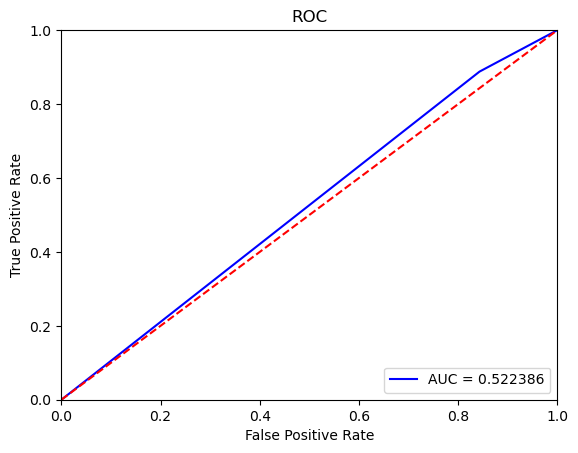

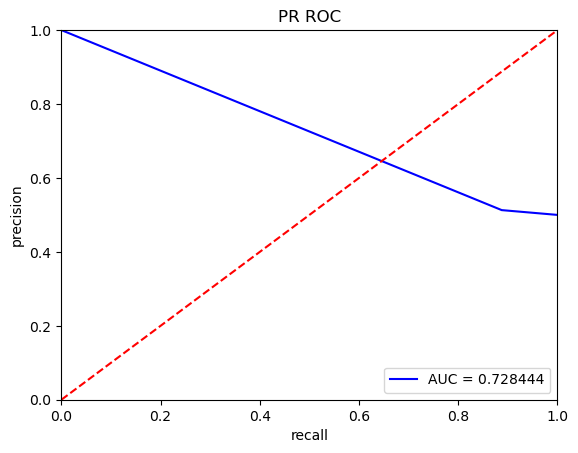

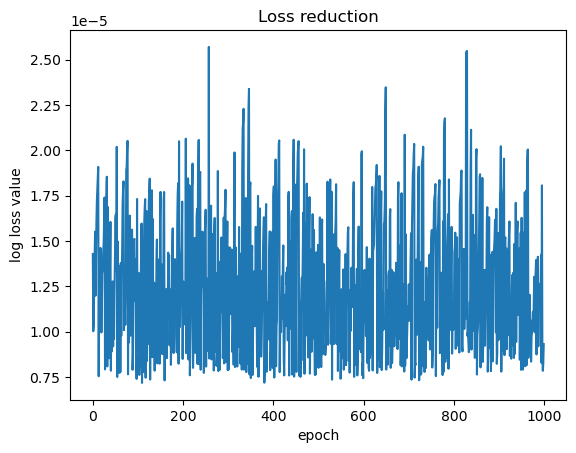

In [23]:
plot_roc_curve(y_true=y_test, y_pred=y_pred_test)
plot_pr_roc_curve(y_true=y_test, y_pred=y_pred_test)
plot_loss_progression(model=model)

> __Ответ__: Существенных изменений не было обнаружено - модель вместе с кодировщиком отработали в тех же временных интервалах. Стоит заметить, что качество предсказаний модели на тестовой выборке понизилось на 1 сотую.

## Часть 3. Отбор признаков (3 балла + 1 бонус)

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом они увеличивают время вычислений) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про обращение клиентов по страховым случаям. Обойдёмся без сэмплирования объектов.

In [24]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

Как вы помните, в данных много категориальных признаков. Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [25]:
%%time

### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

from category_encoders.one_hot import OneHotEncoder

cat_features = X_train.columns[X_train.columns.str.endswith('cat')]

ohe = OneHotEncoder(cols=cat_features)
ohe.fit(X_train)
X_train = ohe.transform(X_train)
X_test = ohe.transform(X_test)

# drop first
X_train.drop(columns=cat_features + '_1', inplace=True)
X_test.drop(columns=cat_features + '_1', inplace=True)


X_train.shape

CPU times: user 10.2 s, sys: 4.77 s, total: 14.9 s
Wall time: 14.9 s


(476169, 213)

> __Ответ__: при удалении первой закодированной категории все было получено 213 признаков

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — ROC-AUC. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [26]:
%%time

### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

CPU times: user 14min 21s, sys: 18min 44s, total: 33min 5s
Wall time: 5min 45s


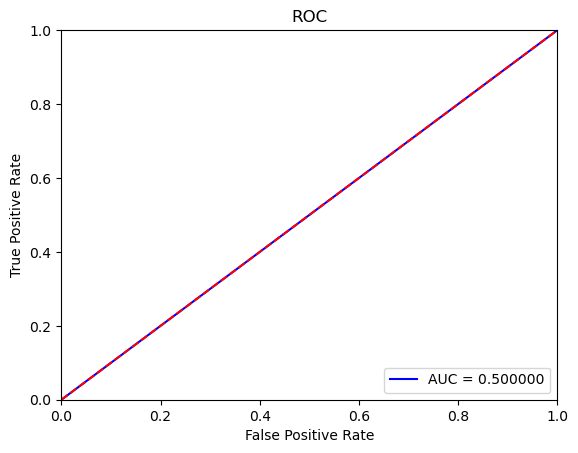

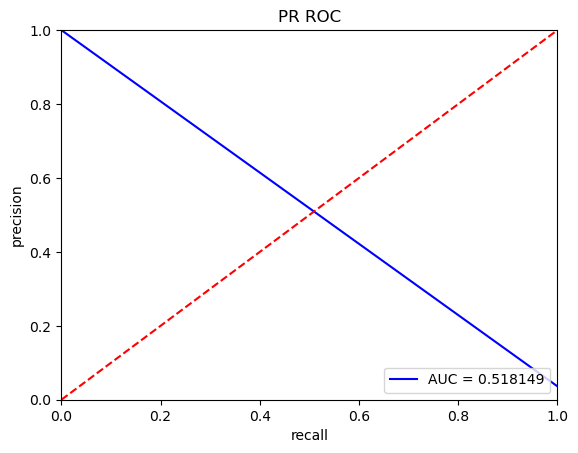

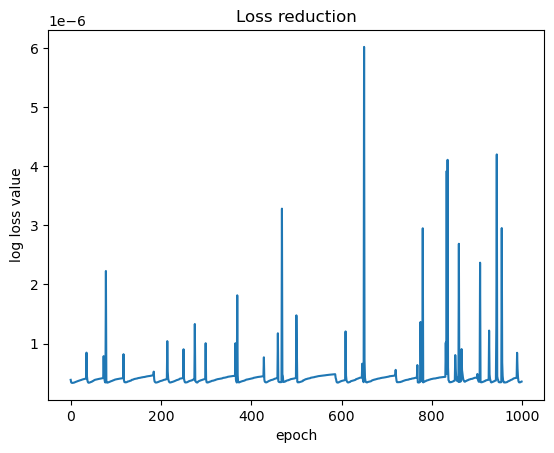

In [27]:
plot_roc_curve(y_true=y_test, y_pred=y_pred_test)
plot_pr_roc_curve(y_true=y_test, y_pred=y_pred_test)
plot_loss_progression(model=model)

### Встроенные методы

Допустим, мы хотим оставить только 200 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 10 (1 балл).__ Оставьте 200 признаков с наибольшим модулем соответсвующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?

In [28]:
%%time
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
values_dict = {'feature_names': X_train.columns, 'values': np.abs(model.w)}

feature_db = pd.DataFrame(values_dict)
best_features = feature_db.sort_values(by=['values'], ascending=False).head(n=200)['feature_names']


X_train_best_features = X_train[best_features]
X_test_best_features = X_test[best_features]

CPU times: user 91.5 ms, sys: 127 ms, total: 219 ms
Wall time: 218 ms


In [29]:
%%time

### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
model.fit(X_train_best_features, y_train)
y_pred_test = model.predict(X_test_best_features)

CPU times: user 13min 18s, sys: 18min 10s, total: 31min 28s
Wall time: 5min 55s


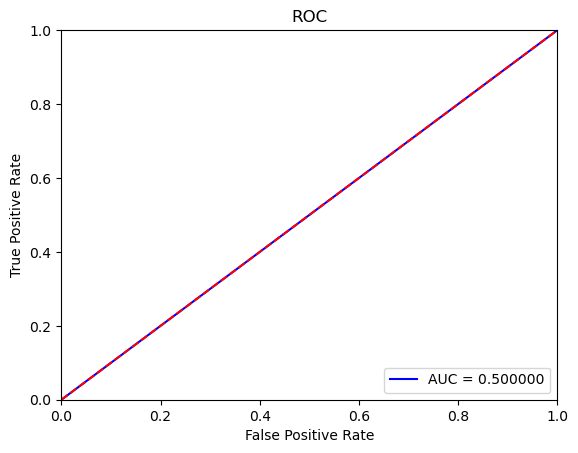

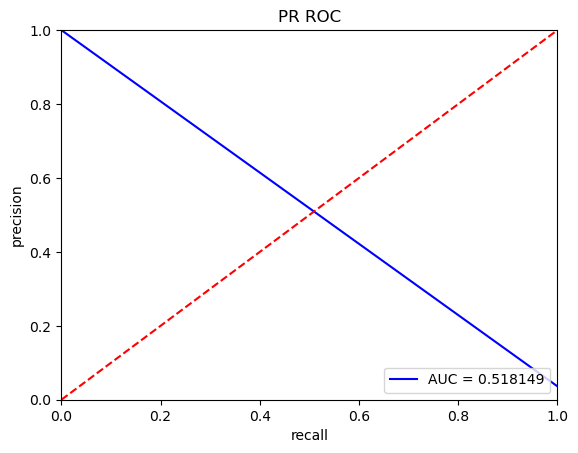

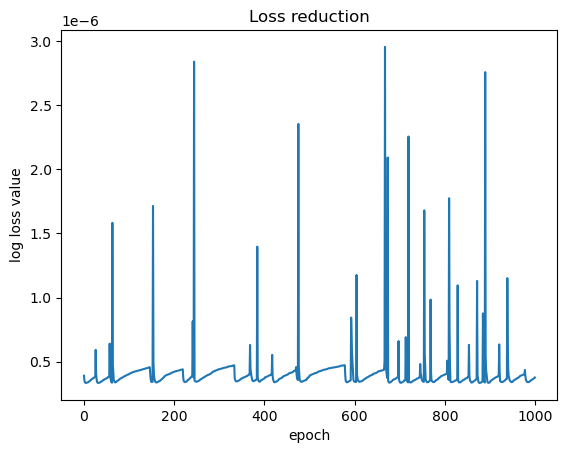

In [30]:
plot_roc_curve(y_true=y_test, y_pred=y_pred_test)
plot_pr_roc_curve(y_true=y_test, y_pred=y_pred_test)
plot_loss_progression(model=model)

> __Ответ__: такой метод отбора признаков отработал довольно быстро. Обучение модели заняло 5 минут. Несмотря на избавление от малозначимых признаков, качество модели никак не улучшилось

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отнормируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [31]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [32]:
%%time
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

CPU times: user 12min 5s, sys: 16min 17s, total: 28min 22s
Wall time: 2min 32s


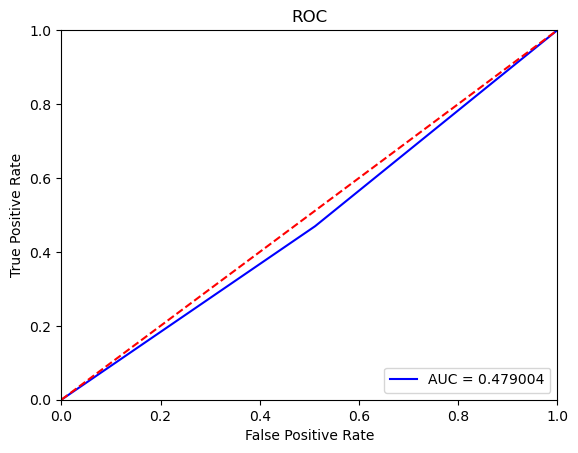

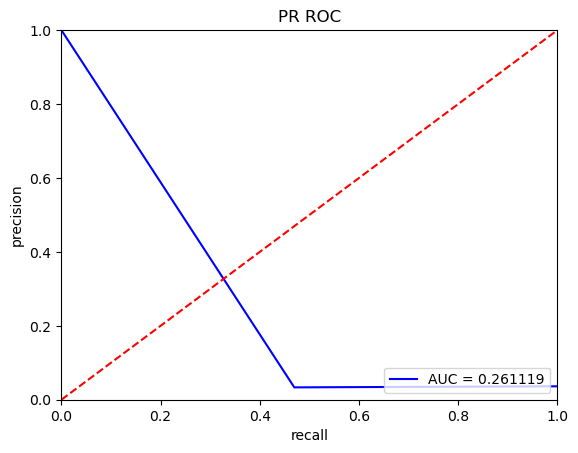

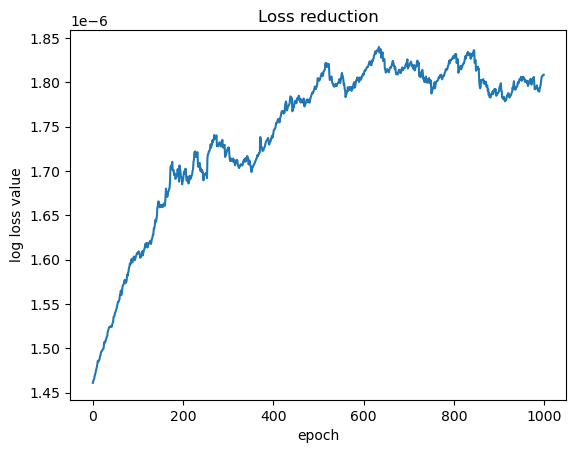

In [33]:
plot_roc_curve(y_true=y_test, y_pred=y_pred_test)
plot_pr_roc_curve(y_true=y_test, y_pred=y_pred_test)
plot_loss_progression(model=model)

In [34]:
# sort pairs of coefs and feature names
values_dict = {'feature_names': X_train.columns, 'values': np.abs(model.w)}

feature_db = pd.DataFrame(values_dict)
best_features = feature_db.sort_values(by=['values'], ascending=False).head(n=200)['feature_names']


X_train_best_features = X_train[best_features]
X_test_best_features = X_test[best_features]

In [35]:
%%time
model.fit(X_train_best_features, y_train)
y_pred_test = model.predict(X_test_best_features)

CPU times: user 11min 9s, sys: 16min 31s, total: 27min 40s
Wall time: 2min 1s


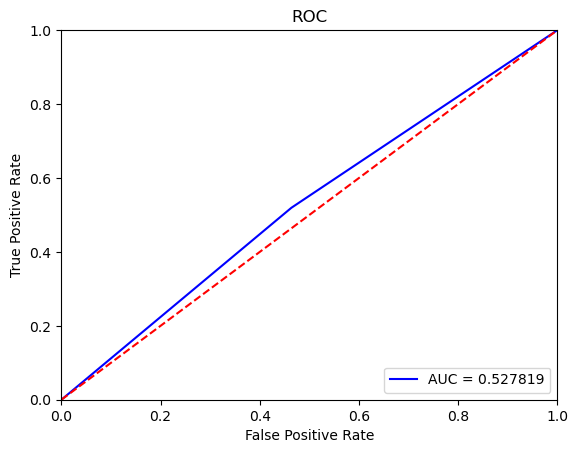

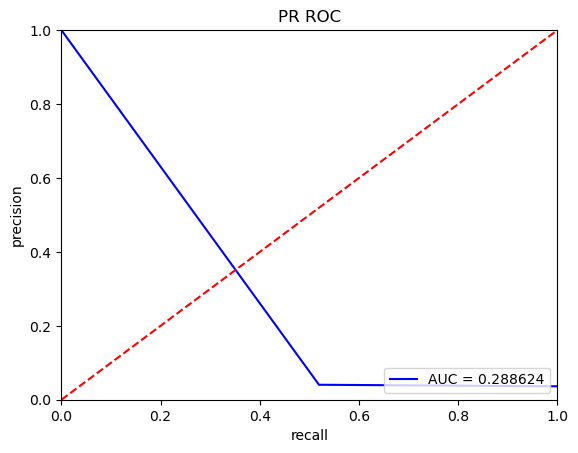

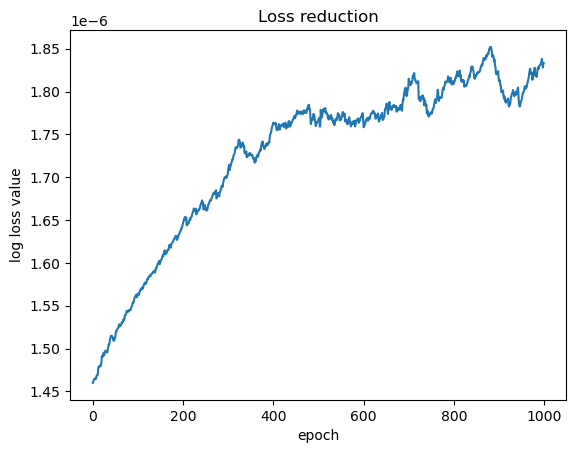

In [36]:
plot_roc_curve(y_true=y_test, y_pred=y_pred_test)
plot_pr_roc_curve(y_true=y_test, y_pred=y_pred_test)
plot_loss_progression(model=model)

> __Ответ__: качество предсказаний модели после стандартизации улучшилось до ROC AUC = 0.52, но несмотря на это PR ROC AUC стал существенно ниже и стал равен 0.28. Это говорит о том, что модель с трудом может предсказывать положительные классы и обладает низкой точностью.

__Задание 10 (0.5 балла).__
Можно задать отбор признаков более функционально. Вспомним, что L1-регуляризация также умеет отбирать признаки. Понятно, что теперь нам будет сложнее оставить именно 200 лучших признаков, но возможно они нам и не нужны. Подберите коэффициент регуляризации и проверьте, как изменилось качество. Получилось ли добиться лучшего качества при менее чем 200 признаках?

In [37]:
%%time
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


model = GridSearchCV(estimator=LogisticRegression(penalty="l1", solver="saga"), cv=3, param_grid={'C': [0.005, 0.02, 0.1]})


model.fit(X_train, y_train)

CPU times: user 12min 32s, sys: 11.5 s, total: 12min 43s
Wall time: 12min 32s


GridSearchCV(cv=3, estimator=LogisticRegression(penalty='l1', solver='saga'),
             param_grid={'C': [0.005, 0.02, 0.1]})

In [38]:
values_dict = {'feature_names': X_train.columns, 'values': model.best_estimator_.coef_[0]}


feature_db = pd.DataFrame(values_dict)

feature_db = feature_db[feature_db['values'] > 0]


X_train_best_features = X_train[feature_db['feature_names']]
X_test_best_features = X_test[feature_db['feature_names']]



In [39]:
%%time
model = LogReg()

model.fit(X_train_best_features, y_train)
y_pred_test = model.predict(X_test_best_features)

CPU times: user 7min 59s, sys: 17min 6s, total: 25min 5s
Wall time: 1min 41s


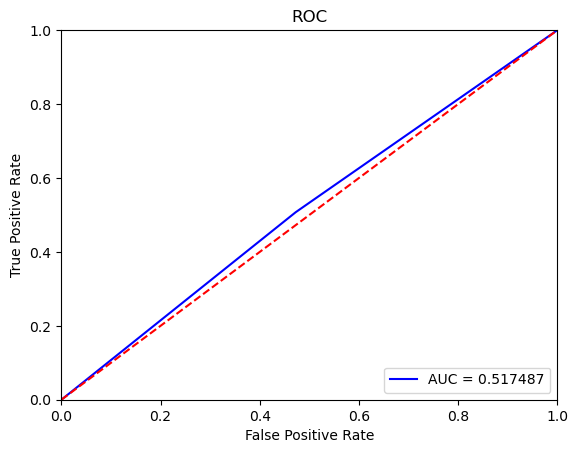

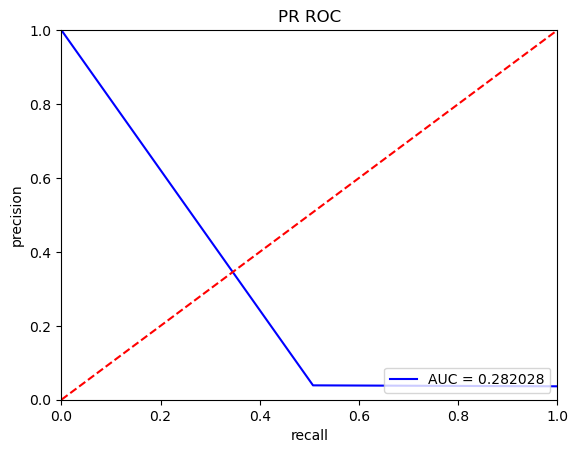

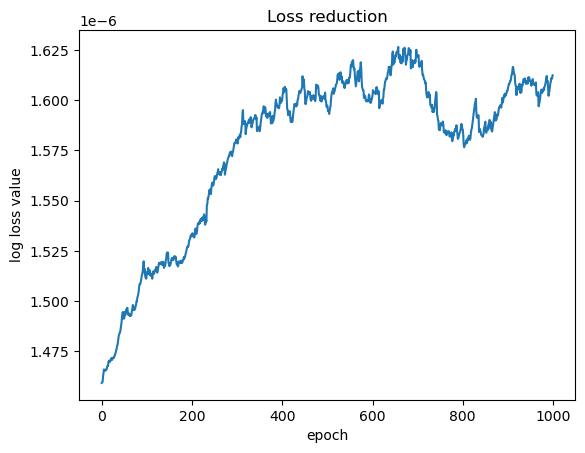

In [40]:
plot_roc_curve(y_true=y_test, y_pred=y_pred_test)
plot_pr_roc_curve(y_true=y_test, y_pred=y_pred_test)
plot_loss_progression(model=model)

> __Ответ__: Качество модели не улучшилось. К тому же мы потратили довольно много времени на то, чтобы подобрать коэффициент регуляризации - 12 минут, что существенно больше чем все предыдущие методы.

### Методы фильтрации

Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $mu$, $sigma$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

Если у вас был курс математической статистики, то вы без труда узнаете статистику гипотезы о разности средних при неизвестных дисперсиях. Если же нет, то интуиция следующая. Вообще мы хотим понять, различаются ли распределения признака для двух разных классов. Мы проверяем, что математические ожидания двух распределений различаются. Если они различаются, значит и сами распределения разные. Отсюда можно сделать вывод, что по этому признаку модель сможет отличить один класс от другого. А если распределения неотличимы и статистика маленькая, то и признак бесполезен. 

Важно оговориться, что хотя мы и не используем статистическое тестирование явно, предпосылки о том, что наблюдения независимы, одинаково распределены и n велико, должны соблюдаться, иначе статистика не имеет смысла. Но у нас большая выборка, поэтому они выполняются. По-хорошему, конечно, надо бы сравнивать статистику с пороговым значением t-распределения и полноценно тестировать гипотезу, но мы обойдёмся простой эвристикой и возьмём признаки с наибольшим значением.


__Задание 11 (1 балл)__. Оставьте 200 признаков с наибольшим значением и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случаев.

In [41]:
%%time
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

from scipy.stats import ttest_ind


X_train['target'] = y_train

statistics = []

for column_name in X_train.columns:
    if column_name != 'target':
        statistics.append(ttest_ind(X_train.loc[X_train['target'] == 1, column_name],
                        X_train.loc[X_train['target'] == 0, column_name]).statistic)
    
X_train.drop(columns=['target'], inplace=True)

values_dict  = {'feature_names': X_train.columns, 't-test statistic': statistics}

feature_db = pd.DataFrame(values_dict)


best_features = feature_db.sort_values(by=['t-test statistic'], ascending=False).head(n=200)['feature_names']
    

CPU times: user 1.44 s, sys: 100 ms, total: 1.54 s
Wall time: 1.54 s


In [42]:
%%time
X_train_best_features = X_train[best_features]
X_test_best_features = X_test[best_features]

model.fit(X_train_best_features, y_train)
y_pred_test = model.predict(X_test_best_features)

CPU times: user 11min 31s, sys: 17min 1s, total: 28min 33s
Wall time: 2min


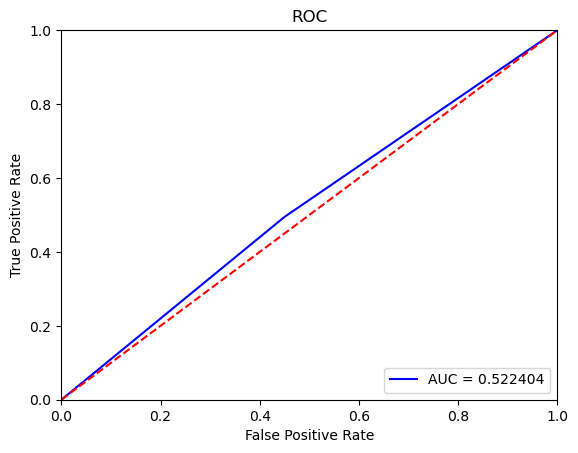

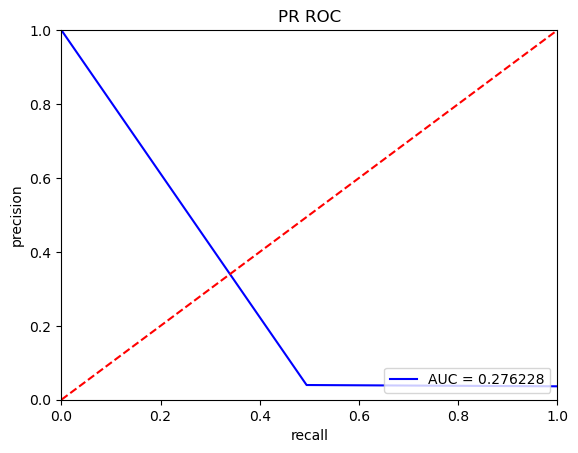

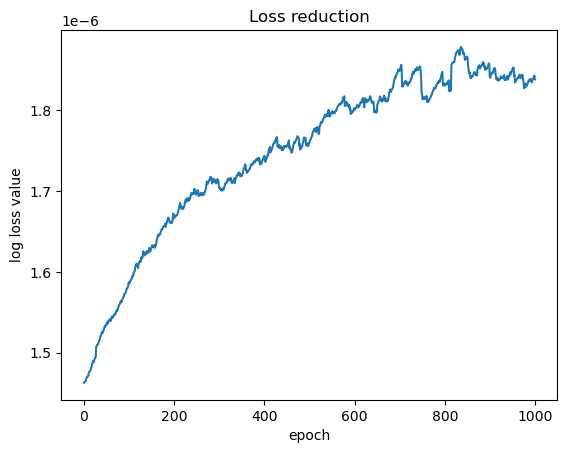

In [43]:
plot_roc_curve(y_true=y_test, y_pred=y_pred_test)
plot_pr_roc_curve(y_true=y_test, y_pred=y_pred_test)
plot_loss_progression(model=model)

> __Ответ__: Статический отбор признаков позволил слегка улучшить ROC AUC = 0.52, но понизил PR ROC AUC до 0.27

### Методы-обёртки

__Задание 12 (бонус, 1 балл)__.


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не достигнем некоторого критерия (количество признаков или ухудшением качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо. 

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 200 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [44]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Опционально (это не оценивается) можете рассмотреть более интересные стратегии отбора, чем жадная. Например, генетические алгоритмы. Можно закодировать бинарным вектором, включаем мы или нет тот или иной признак в модель. А дальше генетическим алгоритмом оптимизировать этот вектор. Всё ещё не быстро, но точно быстрее жадного.


**Задание 13 (0.5 балла)** Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

__Ответ__: Лучшая модель была получена с помощью TargetEncoder без добавления шума со всеми признаками. Данные были не стандартизированы. ROC AUC в для этой модели был равен 0.53 <br>
Данный метод хорош но мы допускаем data leakage в тренировочные данные, но данная проблема решается добавлением случайного шума. С точки зрения производительности Target Encoder существенно быстрее OHE. <br>
Что любопотно ни один из методов отбора параметром не привел к существенному улучшению предсказательных способностей модели. <br>
В данном задании мы попробовали: <br>
* отбор с помощью коэффициентов регрессии без стандартизации. Метод отрабатовал довольно быстро. ROC AUC = 0.5
* отбор с помощью коэффициентов регрессии с стандартизацией. Метод отрабатовал довольно быстро. ROC AUC = 0.527
* отбор с помощью классификации с L1 регуляризацией. Метод отрабатывал довольно долго из-за того, что необходимо было найти лучший коэффициент регуляризации. ROC AUC = 0.5174
* отбор с помощью статистики Стьюдента. Метод отрабатывал довольно быстро. ROC AUC = 0.522404